## 1. Load model and test it

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def preprocess_image(src):
    imsize = 256

    loader = transforms.Compose([
            transforms.Resize((imsize, imsize)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std =[0.229, 0.224, 0.225])])

    image = Image.open(src)
    size = image.size
    image = loader(image).unsqueeze(0).to(device, torch.float)

    return image, size

In [ ]:
device = torch.device("cpu")

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1), # Pads the input tensor using the reflection of the input boundary
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]

        # Unpacking
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [ ]:
model_path = '/content/drive/MyDrive/models/ukiyoe.pk'
model = torch.load(model_path, map_location=torch.device('cpu')).to(device).eval()

In [ ]:
photo_path = '/content/photo_2024-02-09_15-34-23.jpg'
photo, size = preprocess_image(photo_path)
w, h = size

In [ ]:
# plt.imshow(out)

In [ ]:
loader = transforms.Compose([
        transforms.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
        transforms.Resize((h, w))])

In [ ]:
output = model(photo).detach()[0]
res = loader(output).numpy().transpose(1, 2, 0)

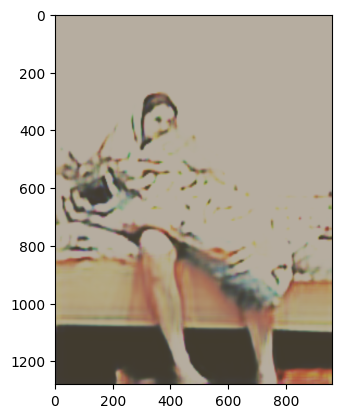

In [ ]:
plt.imshow(res)

## 2. Convert it to .onnx format and check

In [ ]:
!pip install onnx
!pip install onnxruntime

In [ ]:
import onnxruntime as ort
import onnx
import numpy as np

In [ ]:
torch.onnx.export(model,
                  torch.randn(1, 3, 256, 256).to(device),
                  "ukiyoe.onnx",
                  input_names = ['input'],
                  output_names = ['output'])

In [ ]:
onnx_model = onnx.load("/content/ukiyoe.onnx")
onnx.checker.check_model(onnx_model)

## 3. Run using onnxruntime

In [ ]:
ort_sess = ort.InferenceSession("/content/ukiyoe.onnx")
outputs = ort_sess.run(None, {'input': photo.numpy()})

In [ ]:
out = torch.tensor(outputs)[0][0]
res2 = loader(out).numpy().transpose(1, 2, 0)

In [ ]:
np.allclose(res2, res)

True

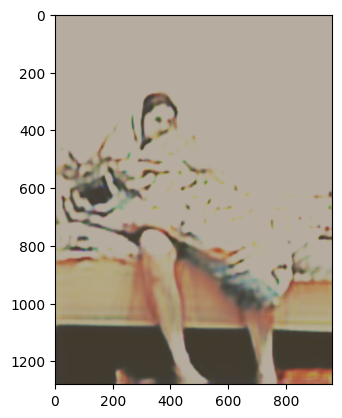

In [ ]:
plt.imshow(res2)